Link to the colab notebook --> https://colab.research.google.com/drive/1DVylAM9JvuoO_L6Yz-9CzpewSwkmX91c?usp=sharing

# Business Problem

A streaming company receives thousands of IMDb-style user reviews daily. The problem is that it is near impossible to manually read the reviews to extract the sentiments of viewers and to identify individual content problems(acting, plot or bugs on the streaming platform). To solve this problem, the company needs an automated and reliable way to classify reviews(whether positive or negative), and highlight the main pain points to enable marketing, product and content teams address these issues in time. This can be done through promotions and content curation.

Solving this problem will benefit the company in many ways. Below are a few of them:


1.   Faster insights: With the help of automated dashboards, the company will gain faster insights into daily sentiment summaries as well as trend alerts.
2.   Prioritization of actions: When recurring problems are identified quickly, resources are allocated to fix them.
3.   Marketing optimization: Titles that have strong positive sentiments are promoted with targeted campaigns.
4.   Personalization and recommendations: Recommendations will be refined according to sentiment signals.


The dataset was collected from the source https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

"This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well. Raw text and already processed bag of words formats are provided."

@InProceedings{maas-EtAl:2011:ACL-HLT2011, author = {Maas, Andrew L. and Daly, Raymond E. and Pham, Peter T. and Huang, Dan and Ng, Andrew Y. and Potts, Christopher}, title = {Learning Word Vectors for Sentiment Analysis}, booktitle = {Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies}, month = {June}, year = {2011}, address = {Portland, Oregon, USA}, publisher = {Association for Computational Linguistics}, pages = {142--150}, url = {http://www.aclweb.org/anthology/P11-1015} }

The raw, uncleaned review text was used. It contains HTML tags, typos, punctuations and varied casing.

For an NLP task, This problem will be tackled by performing binary sentiment analysis(positive/negative)

This high-level NLP system design will be comprised of the following:

**1. Data Ingestion:** Standardization and storing of raw data which will be needed for reproducibilty and traceabilty.

**2. Exploratory Data Analysis:** This will be to understand class balance, text length, common tokens and noise.

**3. Preprocessing:** Two tailored pipelines

*  Aggressive cleaning for N-Gram(to remove HTML, punctuations, stopwords and to lemmatize)
* Minimal claeaning for BERT/GPT(to preserve punctuations or the structure that models use).

**4. Feature Engineering:** Creating features appropriate to each modelling approach
* TF-IDF with n-grams for classic models  
* Tokenization and inputs for BERT fine-tuning
* High-quality dense embeddings(OpenAI GPT embeddings or sentence-transformers) for embedding-classifier pipeline

**5. Model Training and Tuning:** Training N-GRAM, BERT, GPT models and tuning hyperparameters.

**6. Evaluation:** Evaluating each model thoroughly (using metrics, confidence and confidence) and comparing.

**7. Final Discussion of the Overall Pipeline:** Highlighting strengths and limitations of the pipline, business insights of the results, and data-driven recommendations.





**First, the libraries for this task are imported**

In [ ]:
import os
import time
import random
from pathlib import Path
from typing import List, Tuple, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from datasets import load_dataset
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

# For text cleaning
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# For BERT fine-tuning
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          TrainingArguments, Trainer, DataCollatorWithPadding)
import torch

# For offline GPT-like embeddings (sentence-transformers)
from sentence_transformers import SentenceTransformer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


****

# Data Ingestion and Splits

1.   Dataset contains 50000 IMDb reviews: 25k train, 25k test
2.   For splitting, The existing 25k train and 25k test will be kept. From train, a validation set ->90% training and 10% validation(stratified by label) will be created. This validation set will be used for hyperparameter tuning and early stopping for BERT.
3. Original raw data will then be saved as "raw" and the processed dataset will be saved with the metadata.

In [ ]:
ds = load_dataset("imdb")
# ds has 'train' (25k), 'test' (25k), unsupervised subset (not needed)
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [ ]:
# Convert to pandas for EDA convenience
train_df = pd.DataFrame(ds['train'])
test_df  = pd.DataFrame(ds['test'])
train_df['split'] = 'train'
test_df['split']  = 'test'
df = pd.concat([train_df, test_df]).reset_index(drop=True)
df.head()

,text,label,split
0,I rented I AM CURIOUS-YELLOW from my video sto...,0,train
1,"""I Am Curious: Yellow"" is a risible and preten...",0,train
2,If only to avoid making this type of film in t...,0,train
3,This film was probably inspired by Godard's Ma...,0,train
4,"Oh, brother...after hearing about this ridicul...",0,train


# Exploratory Data Analysis


1. Using a bar chart to plot label balance with counts.

2. Using histograms to visualize character counts and token counts.

3. Performing a noise audit to show the percentages of HTML tags, URLs, excessive punctuations and emojis.

4. Detecting missing and duplicate reviews

5. Computing top unigrams and bigrams, overall and per-class(positive/negative).

6. Using a wordcloud to visually inspect common words in both positive and negative reviews.

7. Statistics of character length stats and token count.

label
0    25000
1    25000
Name: count, dtype: int64


<>:29: SyntaxWarning: invalid escape sequence '\ '
<>:29: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-2018102994.py:29: SyntaxWarning: invalid escape sequence '\ '
  print("\ Character length stats:")


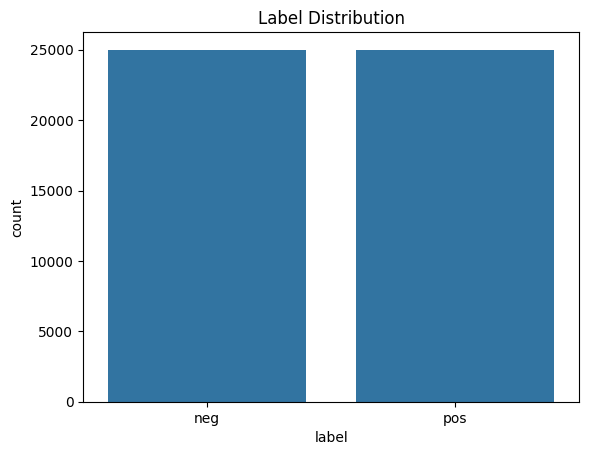

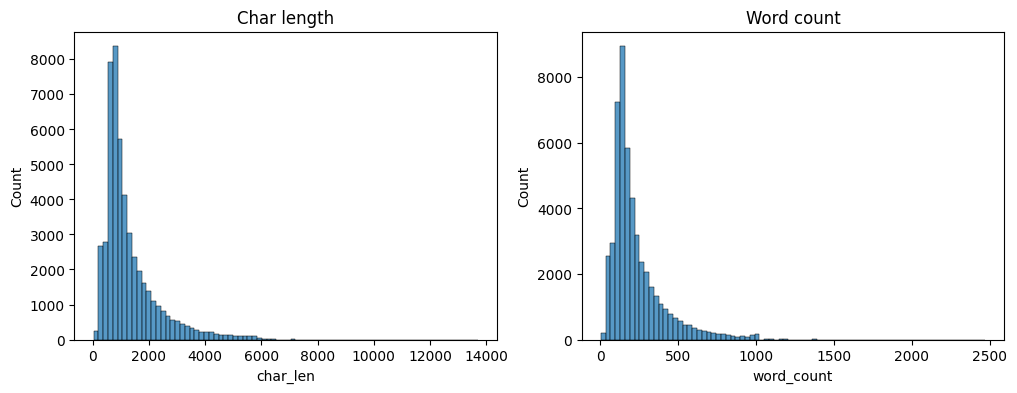

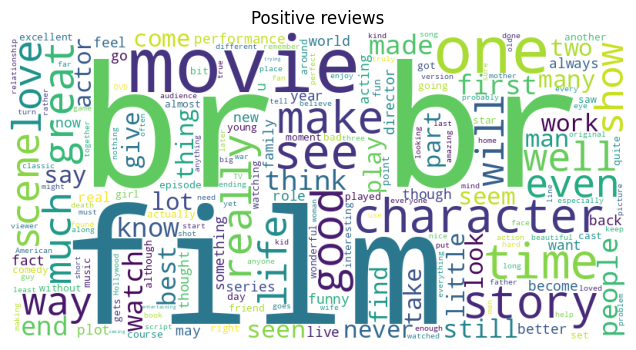

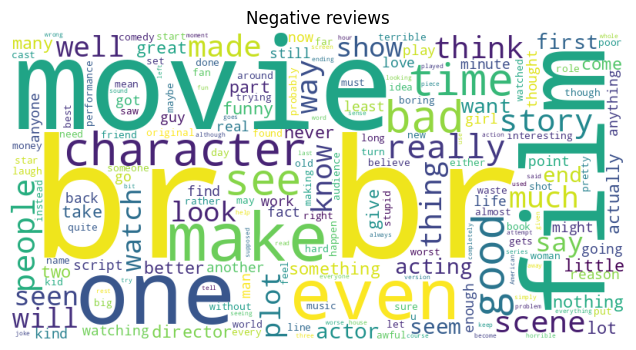

\ Character length stats:
count    50000.000000
mean      1309.431020
std        989.728014
min         32.000000
25%        699.000000
50%        970.000000
75%       1590.250000
max      13704.000000
Name: char_len, dtype: float64

 Token count stats:
count    50000.000000
mean       231.156940
std        171.343997
min          4.000000
25%        126.000000
50%        173.000000
75%        280.000000
max       2470.000000
Name: word_count, dtype: float64


In [ ]:
# Label distribution
print(df.label.value_counts())
sns.countplot(data=df, x='label')
plt.xticks([0,1], ['neg','pos'])
plt.title("Label Distribution")
plt.show()

# Review length histogram (characters & tokens)
df['char_len'] = df['text'].str.len()
df['word_count'] = df['text'].apply(lambda t: len(t.split())) # Using split() for tokenization
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(df['char_len'], bins=80)
plt.title("Char length")
plt.subplot(1,2,2)
sns.histplot(df['word_count'], bins=80)
plt.title("Word count")
plt.show()

# Wordcloud for positive and negative (small sample to speed)
def make_wordcloud(text_series, title):
    text = " ".join(list(text_series.sample(min(3000, len(text_series)), random_state=1)))
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10,4)); plt.imshow(wc); plt.axis('off'); plt.title(title); plt.show()

make_wordcloud(df[df.label==1].text, "Positive reviews")
make_wordcloud(df[df.label==0].text, "Negative reviews")

print("\ Character length stats:")
print(df['char_len'].describe())

print("\n Token count stats:")
print(df['word_count'].describe())

# Preprocessing

Two preprocessing pipelines will be used:

1. Preprocessing for N-Gram: aggressive cleaning for TF-ID (lowercase, removing HTML tags, punctuation, numbers, URLs stopwords, lemmatization)

2. Preprocessing for transformer-BERT/GPT embeddings — minimal cleaning (keep punctuation & casing to some extent, removing HTML tags only, avoiding lemmatization or stopword removal)

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def remove_html(text):
    return re.sub(r'<[^>]+>', ' ', text)

def preprocess_for_ngram(text: str) -> str:
    text = remove_html(text)
    text = text.lower()
    text = re.sub(r'http\S+|www\S+',' ', text)
    text = re.sub(r'[^a-z\s]', ' ', text)  # remove digits and punctuation
    # Changed tokenization from nltk.word_tokenize to text.split()
    tokens = text.split()
    tokens = [tok for tok in tokens if tok not in stop_words and len(tok) > 1]
    tokens = [lemmatizer.lemmatize(tok) for tok in tokens]
    return " ".join(tokens)

def preprocess_for_transformer(text: str) -> str:
    text = remove_html(text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Feature Engineering and Modelling

But first training/validation splits will be created by using the original train/test but creating a validation set from train

In [ ]:
train = df[df.split=='train'].copy()
test  = df[df.split=='test'].copy()

train, val = train_test_split(train, test_size=0.1, random_state=42, stratify=train['label'])

len(train), len(val), len(test)

(22500, 2500, 25000)

**MODEL 1 — N-GRAM (TF-IDF + Classifier)**

1. To filter extremely common or rare items, the vectorizer TfidfVectorizer(max_features=50000, ngram_range=(1,2)) will be applied

2. The classifier used for this model is Logistic Regresion(with saga solver) because Regression often gives the best tradeoff for TF-IDF features

3. Hyperparameters to search(GridSearchCV on validation or cross-validation):

*   C for LogisticRegression: [0.1, 1.0, 3.0]
*   ngram_range: (1,1) vs (1,2)
*   max_features: 10k, 50k




In [ ]:
# Preprocess training text for N-Gram
train['text_ngram'] = train['text'].apply(preprocess_for_ngram)
val['text_ngram'] = val['text'].apply(preprocess_for_ngram)
test['text_ngram'] = test['text'].apply(preprocess_for_ngram)

# TF-IDF vectorizer with unigrams & bigrams
tfidf = TfidfVectorizer(max_features=50000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(train['text_ngram'])
X_val_tfidf   = tfidf.transform(val['text_ngram'])
X_test_tfidf  = tfidf.transform(test['text_ngram'])

y_train = train['label'].values
y_val   = val['label'].values
y_test  = test['label'].values

# Train a Logistic Regression with simple hyperparam search
lr = LogisticRegression(max_iter=200, solver='saga', n_jobs=-1)
params = {'C':[0.1, 1.0, 3.0]}
cv = GridSearchCV(lr, params, cv=3, scoring='f1', n_jobs=-1)
cv.fit(X_train_tfidf, y_train)
print("Best params:", cv.best_params_)
best_lr = cv.best_estimator_

# Evaluate
def eval_model(clf, X, y, name="model"):
    ypred = clf.predict(X)
    acc = accuracy_score(y, ypred)
    prec, rec, f1, _ = precision_recall_fscore_support(y, ypred, average='binary')
    return {'name': name, 'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'y_true': y, 'y_pred': ypred}

res_ngram_val = eval_model(best_lr, X_val_tfidf, y_val, name='NGram-LR')
res_ngram_test = eval_model(best_lr, X_test_tfidf, y_test, name='NGram-LR-test')
res_ngram_val, res_ngram_test


Best params: {'C': 3.0}


({'name': 'NGram-LR',
  'accuracy': 0.9028,
  'precision': 0.894283476898982,
  'recall': 0.9136,
  'f1': 0.9038385437277404,
  'y_true': array([0, 0, 0, ..., 0, 1, 1]),
  'y_pred': array([0, 0, 0, ..., 0, 1, 1])},
 {'name': 'NGram-LR-test',
  'accuracy': 0.88896,
  'precision': 0.8914653784219002,
  'recall': 0.88576,
  'f1': 0.8886035313001606,
  'y_true': array([0, 0, 0, ..., 1, 1, 1]),
  'y_pred': array([0, 0, 0, ..., 1, 0, 1])})

It can be seen from the output that the N-Gram model performed slightly better on the validation set(f1:0.9038385437277404) than on the test set(f1:0.8886035313001606)

**MODEL 2 — BERT (fine-tune with Hugging Face)**

1.   The model used is distilbert-base-uncased.
2.   For tokenization, Hugging Face AutoTokenizer with max_length=256 and truncation=True
3. The metrics used are cross-entropy loss;compute accuracy, precision, recall and F1 each val step.
4. For hardware, T4-GPU was used in order to reduce training time.

In [ ]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Tokenize function
def tokenize_fn(examples):
    return tokenizer(examples["text"], truncation=True, padding=False, max_length=256)

# Convert subsets to HF datasets for Trainer
import datasets as hf_datasets
train_hf = hf_datasets.Dataset.from_pandas(train[['text','label']])
val_hf   = hf_datasets.Dataset.from_pandas(val[['text','label']])
test_hf  = hf_datasets.Dataset.from_pandas(test[['text','label']])

train_hf = train_hf.map(lambda x: {'text': x['text']})
val_hf   = val_hf.map(lambda x: {'text': x['text']})
test_hf  = test_hf.map(lambda x: {'text': x['text']})

train_tok = train_hf.map(lambda x: tokenizer(x['text'], truncation=True, padding='max_length', max_length=256), batched=True)
val_tok   = val_hf.map(lambda x: tokenizer(x['text'], truncation=True, padding='max_length', max_length=256), batched=True)
test_tok  = test_hf.map(lambda x: tokenizer(x['text'], truncation=True, padding='max_length', max_length=256), batched=True)

# set format for pytorch
columns = ['input_ids', 'attention_mask', 'label']
train_tok.set_format(type='torch', columns=columns)
val_tok.set_format(type='torch', columns=columns)
test_tok.set_format(type='torch', columns=columns)

data_collator = DataCollatorWithPadding(tokenizer)

training_args = TrainingArguments(
    output_dir="./distilbert-imdb",
    eval_strategy="epoch", # Changed from evaluation_strategy to eval_strategy
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    logging_steps=100
)

# compute_metrics for Trainer
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = (preds == labels).mean()
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Train
trainer.train()

# Evaluate on test
metrics = trainer.evaluate(eval_dataset=test_tok)
metrics

# API key for logging in to the wandb library -> 6df4437a9de5d23047ce6399892e3cdfebded3fb

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/22500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/22500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

/tmp/ipython-input-2236590657.py:53: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: princess-dagadu (princess-dagadu-gisma-business-school) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.263400,0.235459,0.907200,0.893963,0.924000,0.908733
2,0.168000,0.273584,0.915200,0.911252,0.920000,0.915605


{'eval_loss': 0.22506071627140045,
 'eval_accuracy': 0.90992,
 'eval_precision': 0.8945787771446173,
 'eval_recall': 0.92936,
 'eval_f1': 0.9116377619084988,
 'eval_runtime': 172.7648,
 'eval_samples_per_second': 144.705,
 'eval_steps_per_second': 4.526,
 'epoch': 2.0}

This indicates that the DistilBERT model achieved a high accuracy and F1 score. This simply means that it performs well in classifying movie reviews as positive or negative. The recall being slightly higher than the precision suggests that the model is slightly better at finding positive reviews that avoiding misclassifying negative reviews as positive.

**MODEL 3 — GPT EMBEDDINGS + CLASSIFIER**

Two approaches:

A. Using OpenAI GPT embeddings(cloud)

B. Using sentence-transformers models(offline)

Option A — Using OpenAI GPT embeddings (with an API key)

Embeddings for each review are computed and then a classifier is trained on the embeddings. Logstic Regression is the classifier used. The advantage of this option is that no fine tuning is required and also its iteration and deployment is relatively fast.

In [ ]:
# Use a sentence-transformer model
sbert_model_name = "all-MiniLM-L6-v2"
sbert = SentenceTransformer(sbert_model_name)

# Compute embeddings
X_train_emb = sbert.encode(train['text'].tolist(), show_progress_bar=True, batch_size=64)
X_val_emb   = sbert.encode(val['text'].tolist(), show_progress_bar=True, batch_size=64)
X_test_emb  = sbert.encode(test['text'].tolist(), show_progress_bar=True, batch_size=64)

# Train a logistic regression on embeddings
clf_emb = LogisticRegression(max_iter=300, C=1.0, n_jobs=-1)
clf_emb.fit(X_train_emb, y_train)
res_gpt_val = eval_model(clf_emb, X_val_emb, y_val, name='SBERT-LR')
res_gpt_test = eval_model(clf_emb, X_test_emb, y_test, name='SBERT-LR-test')

res_gpt_val, res_gpt_test

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/352 [00:00<?, ?it/s]

Batches:   0%|          | 0/40 [00:00<?, ?it/s]

Batches:   0%|          | 0/391 [00:00<?, ?it/s]

({'name': 'SBERT-LR',
  'accuracy': 0.818,
  'precision': 0.8098207326578332,
  'recall': 0.8312,
  'f1': 0.8203711014607186,
  'y_true': array([0, 0, 0, ..., 0, 1, 1]),
  'y_pred': array([0, 0, 0, ..., 0, 1, 0])},
 {'name': 'SBERT-LR-test',
  'accuracy': 0.81068,
  'precision': 0.813564796124344,
  'recall': 0.80608,
  'f1': 0.8098051034759896,
  'y_true': array([0, 0, 0, ..., 1, 1, 1]),
  'y_pred': array([0, 1, 0, ..., 0, 0, 1])})

Based on the output above, the SBERT+Logistic Regression model achieved an F1 score of 0.8098051034759896 on the test set. This indicates a lower performance compared to the previous models.

Option B — Offline alternative using sentence-transformers

Embeddings for each review are computed offline and then a classifier is trained on the embeddings. Logstic Regression is the classifier used. The hyperparameter used here is regularization C for LR

In [ ]:
# Use a sentence-transformer model
sbert_model_name = "all-MiniLM-L6-v2"
sbert = SentenceTransformer(sbert_model_name)

# Compute embeddings
X_train_emb = sbert.encode(train['text'].tolist(), show_progress_bar=True, batch_size=64)
X_val_emb   = sbert.encode(val['text'].tolist(), show_progress_bar=True, batch_size=64)
X_test_emb  = sbert.encode(test['text'].tolist(), show_progress_bar=True, batch_size=64)

# Train a logistic regression on embeddings
clf_emb = LogisticRegression(max_iter=300, C=1.0, n_jobs=-1)
clf_emb.fit(X_train_emb, y_train)
res_gpt_val = eval_model(clf_emb, X_val_emb, y_val, name='SBERT-LR')
res_gpt_test = eval_model(clf_emb, X_test_emb, y_test, name='SBERT-LR-test')

res_gpt_val, res_gpt_test

Batches:   0%|          | 0/352 [00:00<?, ?it/s]

Batches:   0%|          | 0/40 [00:00<?, ?it/s]

Batches:   0%|          | 0/391 [00:00<?, ?it/s]

({'name': 'SBERT-LR',
  'accuracy': 0.818,
  'precision': 0.8098207326578332,
  'recall': 0.8312,
  'f1': 0.8203711014607186,
  'y_true': array([0, 0, 0, ..., 0, 1, 1]),
  'y_pred': array([0, 0, 0, ..., 0, 1, 0])},
 {'name': 'SBERT-LR-test',
  'accuracy': 0.81068,
  'precision': 0.813564796124344,
  'recall': 0.80608,
  'f1': 0.8098051034759896,
  'y_true': array([0, 0, 0, ..., 1, 1, 1]),
  'y_pred': array([0, 1, 0, ..., 0, 0, 1])})

Based on the output above, the SBERT+Logistic Regression model(offline) achieved an F1 score of 0.8098051034759896 on the test set. This indicates a lower performance compared to the previous models.

# Evaluation

A comparison table will be with metrics will be produced. This gives an overview of the performance of all three models.

Some visualization in the form of confusion matrices to inspect specific error types in all three models.

In [ ]:
# Results computed:
results = []

# N-Gram - res_ngram_test
results.append({
    'model': 'NGram-TFIDF-LR',
    'accuracy': res_ngram_test['accuracy'],
    'precision': res_ngram_test['precision'],
    'recall': res_ngram_test['recall'],
    'f1': res_ngram_test['f1']
})

# BERT metrics collected from trainer.evaluate
bert_metrics = metrics  # from trainer.evaluate
results.append({
    'model': 'DistilBERT-finetuned',
    'accuracy': bert_metrics.get('eval_accuracy') or bert_metrics.get('accuracy'),
    'precision': bert_metrics.get('eval_precision') or bert_metrics.get('precision'),
    'recall': bert_metrics.get('eval_recall') or bert_metrics.get('recall'),
    'f1': bert_metrics.get('eval_f1') or bert_metrics.get('f1')
})

# GPT/SBERT
results.append({
    'model': 'SBERT-LR',
    'accuracy': res_gpt_test['accuracy'],
    'precision': res_gpt_test['precision'],
    'recall': res_gpt_test['recall'],
    'f1': res_gpt_test['f1']
})

results_df = pd.DataFrame(results).sort_values('f1', ascending=False)
results_df

,model,accuracy,precision,recall,f1
1,DistilBERT-finetuned,0.90992,0.894579,0.92936,0.911638
0,NGram-TFIDF-LR,0.88896,0.891465,0.88576,0.888604
2,SBERT-LR,0.81068,0.813565,0.80608,0.809805


Model Comparison Summary

Based on the evaluation metrics on the test set, the **fine-tuned DistilBERT model** demonstrated the strongest performance, achieving an F1 score of approximately **0.911**, an accuracy of around **0.909**, a precision of about **0.894**, and a recall of approximately **0.929**.

The **NGram-TFIDF-LR model** also performed well with an F1 score of about 0.888, while the SBERT-LR model had the lowest performance with an F1 score of around 0.809.

Therefore, the DistilBERT model is the most suitable choice among the evaluated models for this binary sentiment classification task.

**Confusion Matrices**

The confusion matrices visually display how many instances of each class were correctly and incorrectly classified. This helps to understand the types of errors the model makes; false positives and false negatives.

The classification reports provide a more detailed breakdown of the performance metrics per class.

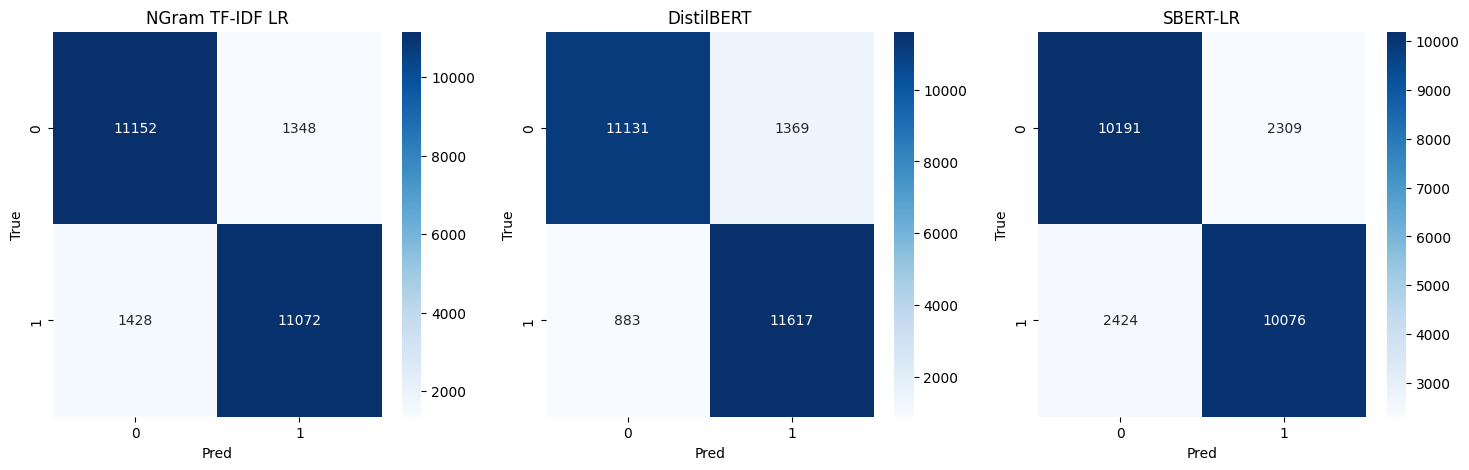

NGram report:
               precision    recall  f1-score   support

         neg       0.89      0.89      0.89     12500
         pos       0.89      0.89      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

BERT report:
               precision    recall  f1-score   support

         neg       0.93      0.89      0.91     12500
         pos       0.89      0.93      0.91     12500

    accuracy                           0.91     25000
   macro avg       0.91      0.91      0.91     25000
weighted avg       0.91      0.91      0.91     25000

SBERT report:
               precision    recall  f1-score   support

         neg       0.81      0.82      0.81     12500
         pos       0.81      0.81      0.81     12500

    accuracy                           0.81     25000
   macro avg       0.81      0.81      0.81     25000
weighted avg       0.81      0

In [ ]:
# NGram test confusion
import seaborn as sns
fig, axs = plt.subplots(1,3, figsize=(18,5))

def plot_cm(y_true, y_pred, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(title); ax.set_xlabel('Pred'); ax.set_ylabel('True')

# NGram
plot_cm(res_ngram_test['y_true'], res_ngram_test['y_pred'], axs[0], 'NGram TF-IDF LR')
# BERT predictions (use trainer.predict)
bert_preds = trainer.predict(test_tok)
bert_pred_labels = np.argmax(bert_preds.predictions, axis=-1)
plot_cm(y_test, bert_pred_labels, axs[1], 'DistilBERT')
# SBERT
plot_cm(res_gpt_test['y_true'], res_gpt_test['y_pred'], axs[2], 'SBERT-LR')
plt.show()

# Detailed classification reports
print("NGram report:\n", classification_report(res_ngram_test['y_true'], res_ngram_test['y_pred'], target_names=['neg','pos']))
print("BERT report:\n", classification_report(y_test, bert_pred_labels, target_names=['neg','pos']))
print("SBERT report:\n", classification_report(res_gpt_test['y_true'], res_gpt_test['y_pred'], target_names=['neg','pos']))

The three plots are confusion matrices for the NGram, DistilBERT, and SBERT-LR models, respectively. Each matrix shows the counts of:

True Negatives (Top-Left): Correctly predicted negative reviews.

False Positives (Top-Right): Negative reviews incorrectly predicted as positive.

False Negatives (Bottom-Left): Positive reviews incorrectly predicted as negative.

True Positives (Bottom-Right): Correctly predicted positive reviews.

For example, in the **DistilBERT** confusion matrix:

-11131 reviews were correctly predicted as negative (True Negatives).

-1369 reviews were incorrectly predicted as positive (False Positives).

-883 reviews were incorrectly predicted as negative (False Negatives).

-11617 reviews were correctly predicted as positive (True Positives).

# Final Discussion on the Overall Pipeline

**Overall strengths of the pipeline**

1.   End-to-End Automation: This pipeline takes raw IMDb reviews, cleans them, performs feature engineering, and produces sentiment predictions accordingly.
2.   Multiple Modelling Approaches: N-Gram, BERT and GPT embeddings provide a robust comparison across classical Machine Learning and modern transformer-based methods.
3. Context-Aware Representation: BERT and GPT embeddings capture word meaning in context, improving classification of nuanced reviews.
4. Business-Actionable Insights: This pipeline not only predicts sentiments but also highlights frequent words/phrases that drive positive or negative feedback.

**Limitations of the Pipeline**

1.   Compute and Resource Constraints: Fine-tuning BERT or generating GPT embeddings can be expensive on large datasets.
2.   Inference Latency: Transformer Models(BERT/GPT) are slower at inference compared to N-Gram models, which may affect real-time deployment.
3. Limited Label Scope: The task is binary classification(positive/negative) and does not capture mixed or neutral sentiments.
4. Potential Overfitting: With smaller training subsets, fine-tuned BERT could overfit if not carefully regularized.

**Business Implications of the Results**

1.   High Accuracy with brings about Competitive Advantage: Consistently predicting sentiment allows for faster identification of content that users prefer.
2.   Customer Experience Personalization: Positive/negative sentiment data can feed into recommendation sysyems which will improve user engagement.
3. Marketing Optimization: Insights into common praise/complaint words can guide advertising campaigns and messaging.
4. Strategic Decision-Making: Understanding audience mood helps decide which genres, actors or directors drive higher satisfaction.

**Data-driven Recommendations**

1.   Include neutral/mixed categories for a more ganular understanding of user sentiments.
2.   Connect to real-time review streams(eg. social media, app feedback) to monitor sentiment continuously.
3. Periodically train the model with new reviews to adapt to changing language patterns, slang, and cultural trends.
